# Rough crowding estimates, BAADE vs SWEEPS #

**2016-07-20 (WIC):** This is a simple look at the raw photometry from a pair of similar ACS/WFC/F814 images, taken at two bulge fields: BAADE and SWEEPS, to try to compare crowding between the fields.

I went for the simplest measure I could think of here: find two similar exposures at similar setup, one towards SWEEPS, one towards BAADE, and compare the surface density of detected stars at least as bright as each instrumental magnitude. 

### "Results" ###

* The SWEEPS field appears to be **roughly** 1.5 times as crowded as BAADE. That is, ACS/WFC detects about 1.5 times as many stars per square arcsecond in the SWEEPS field as in the BAADE field, comparing single exposures at the same filter.

* Judging by the apparent magnitude histogram, the BAADE exposure may have a *slightly* deeper completeness limit at $F814W$ compared to SWEEPS.

* The differences in the apparent magnitude distributions between the two fields are quite interesting. For example, the Anderson & King routines seem to detect a higher number of saturated objects than in BAADE. This could be down to field selection, perhaps the investigators of the BAADE observations (including RMR) aimed their observation to minimize the number of very bright objects.  

### More information ###

I went for the simplest measure I could think of here: find two similar exposures at similar setup, one towards SWEEPS, one towards BAADE, and find the surface density of detected stars at least as bright as each instrumental magnitude. 

Stars are detected using Jay Anderson's single-frame photometry routine, with the effective PSF library appropriate for 2003, when both images were taken. The image files are specified below, here's some relevant header information:

*  BAADE: **347s in F814W,** DATE-OBS=2003-07-06, $(\alpha, \delta)_{J2000.0}$ = (270.79233, -29.8594), PropID = 9818 (Kuijken)

* SWEEPS: **348s in F814W,** DATE-OBS=2003-06-09, $(\alpha, \delta)_{J2000.0}$ = (269.7533, -29.2000), PropID = 9750 (Sahu)

I have performed very little quality control on the photometry, only selecting stars passing reasonably generous cuts on aperture-to-PSF flux. (This may contribute to the completeness at the faint end, but at least it should be similar in both exposures). Straight side-by-side comparison should allow a decent measure of the crowding in the two cases.

In [80]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pylab as plt
from matplotlib.colors import LogNorm
plt.style.use('ggplot')
%matplotlib inline

In [81]:
from astropy.table import Table

## A couple of handy methods ##

In [103]:
def getPhotom(inPath='j8oz05iuq_flt_noOverflow.xymc', qHi = 0.8, magBri=-99.):
    
    """Quick routine to read and quality-select input data"""
    
    tRaw = Table.read(inPath, format='ascii')

    lNames = ['xC', 'yC', 'mC', 'xR', 'yR', 'mR', 'q']
    for iName in range(len(lNames)):
        tRaw.rename_column('col%i' % (iName+1), lNames[iName])
    
    bGood = (tRaw['q'] > 0.) & (tRaw['q'] < qHi) & (tRaw['mC'] > magBri)

    return tRaw[bGood]

In [104]:
def returnCDF(x):
    
    lSor = np.argsort(x)
    lUp = np.arange(np.size(x))
    return x[lSor], lUp

## File choices ##

In [105]:
filBAADE = 'j8oz05iuq_flt_noOverflow.xymc'
filSWEEPS = '../9750/j8q604g8q_flt_noOverflow.xymc'

## Import the data, select on 'quality' ##

In [106]:
# Load the data and select on quality
brightestMag = -99.9
#brightestMag = -13.7  # uncomment to ignore saturated objects
tBaade = getPhotom(filBAADE, qHi=0.8, magBri=brightestMag)
tSWEEPS = getPhotom(filSWEEPS, qHi=0.8, magBri=brightestMag)

## Estimate crowding as N ( < f814w ) per square arcsecond ##

In [107]:
# Field area on the sky
sX = 202.
sY = 202.
areaArcsec2 = sX * sY

In [108]:
# Create the CDF in magnitude (i.e. number of stars detected 
# that are at least as bright as magnitude mC)
magBA, cdfBA = returnCDF(tBaade['mC'])
magSW, cdfSW = returnCDF(tSWEEPS['mC'])

In [109]:
# Convert to density of stars on the sky at least as bright as mC
crBA = cdfBA/np.float(areaArcsec2)
crSW = cdfSW/np.float(areaArcsec2)

In [110]:
# create interpolation objects for easy evaluation
interpBA = interp1d(magBA, crBA, 'linear', bounds_error=False)
interpSW = interp1d(magSW, crSW, 'linear', bounds_error=False)

## Evaluate the crowding for some instrumental magnitude ##

In [116]:
mInst = -9.0
cBA = interpBA(mInst)
cSW = interpSW(mInst)
print "BAADE:  %.3f stars/sq arcsec at F814W < %.2f" % (cBA, mInst)
print "SWEEPS: %.3f stars/sq arcsec at F814W < %.2f" % (cSW, mInst)
print "SWEEPS/BAADE: %.2f at F814W < %.2f" % (cSW / cBA, mInst)

BAADE:  1.441 stars/sq arcsec at F814W < -9.00
SWEEPS: 2.019 stars/sq arcsec at F814W < -9.00
SWEEPS/BAADE: 1.40 at F814W < -9.00


## Some plots ##

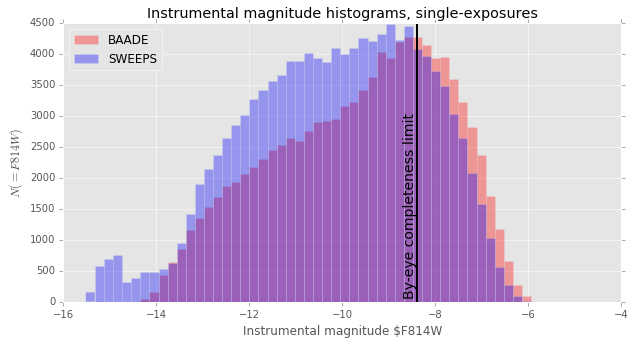

In [117]:
# Plot the histogram to get an idea of where the single-exposure
# completeness breaks down
nBins = 50
xBins = np.linspace(np.min(tSWEEPS['mC']), np.max(tSWEEPS['mC']), nBins)
plt.figure(1, figsize=(10,5))
plt.clf()
nBA, d, d = plt.hist(tBaade['mC'], bins=xBins, color='r', alpha=0.35, label='BAADE')
nSW, d, d = plt.hist(tSWEEPS['mC'], bins=xBins, color='b', alpha=0.35, label='SWEEPS')
plt.legend(loc=2)

# Setting the completeness cut-off (by eye!)
mCut = -8.4
yHi = np.copy(plt.ylim())[-1]
plt.plot([mCut, mCut], [0., yHi], 'k-', lw=2) 
plt.title('Instrumental magnitude histograms, single-exposures')
plt.xlabel(r'Instrumental magnitude $F814W')
plt.ylabel(r'$N(=F814W)$')

plt.annotate('By-eye completeness limit', (mCut-0.3, 50.,), xycoords='data',\
            ha='left', va='bottom', rotation=90., fontsize=14)

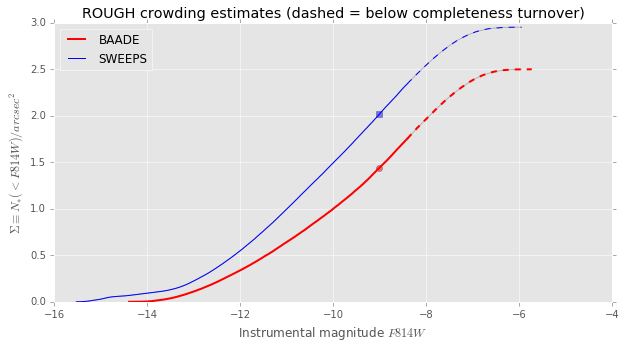

In [122]:
# plot the CDF and select by above/below completeness level
brBA = (magBA < mCut)
brSW = (magSW < mCut)

plt.figure(2, figsize=(10,5))
plt.plot(magBA[brBA], crBA[brBA], label='BAADE', color='r', lw=2, zorder=5)
plt.plot(magSW[brSW], crSW[brSW], label='SWEEPS', color='b', lw=1, zorder=5)
plt.plot(magBA[~brBA], crBA[~brBA], color='r', lw=2, ls='--', zorder=4)
plt.plot(magSW[~brSW], crSW[~brSW], color='b', lw=1, ls='--', zorder=4)

# plot the interpolation just to check...
plt.plot(xBins, interpBA(xBins), color='0.5', alpha=0.5, zorder=1)
plt.plot(xBins, interpSW(xBins), color='0.5', alpha=0.5, zorder=1)

plt.xlabel(r'Instrumental magnitude $F814W$')
plt.ylabel(r'$\Sigma \equiv N_{\ast}(< F814W) / arcsec^2$')
plt.title('ROUGH crowding estimates (dashed = below completeness turnover)')
plt.legend(loc=2)

# overplot our chosen instrumental magnitude
#plt.plot([mInst, mInst], [0., cBA], 'r-', alpha=0.2, lw=1)  # overkill
plt.plot(mInst, cBA, 'ro', alpha=0.5)

plt.plot(mInst, cSW, 'bs', alpha=0.5)

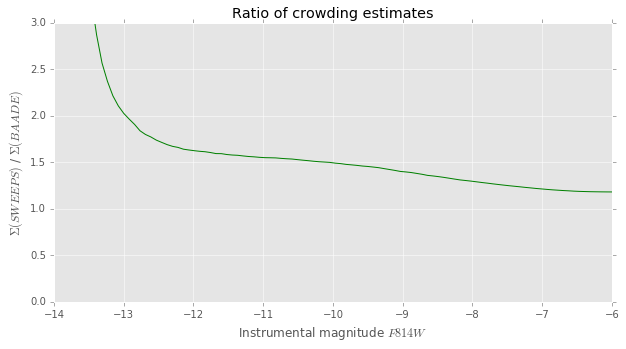

In [121]:
# let's plot the ratio - why not...

xInterp = np.linspace(-13.7, -6., 100)

plt.figure(3, figsize=(10,5))
plt.clf()
plt.plot(xInterp, interpSW(xInterp)/interpBA(xInterp), 'g-')
plt.ylim(0., 3)
plt.xlabel(r'Instrumental magnitude $F814W$')
plt.ylabel(r'$\Sigma(SWEEPS)$ / $\Sigma(BAADE)$')
plt.title('Ratio of crowding estimates')